In [79]:
import numpy as np
from Bio.Seq import Seq
# import itertools
import torch
import pandas as pd
import sys
sys.path.append("scripts/")
from ixnos import iXnos#, encode
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("src/")
from src import legend_kwargs

In [80]:
ansari_n5p4 = iXnos(min_codon=-5, max_codon=4)
ansari_n5p4.load_state_dict(torch.load("processed-data/thp1_v2/models/ixnos_n5p4_full.pth"))
ansari_n5p4.eval() 

ansari_n3p2 = iXnos(min_codon=-3, max_codon=2)
ansari_n3p2.load_state_dict(torch.load("processed-data/thp1_v2/models/ixnos_n3p2_full.pth"))
ansari_n3p2.eval() 

iwasaki_n5p4 = iXnos(min_codon=-5, max_codon=4)
iwasaki_n5p4.load_state_dict(torch.load("models/ixnos_retrained.pth"))
iwasaki_n5p4.eval() 

iwasaki_n3p2 = iXnos(min_codon=-3, max_codon=2)
iwasaki_n3p2.load_state_dict(torch.load("processed-data/iwasaki/models/ixnos_n3p2_full.pth"))
iwasaki_n3p2.eval() 

def apply_models(df, seq_col):
    df["ansari_n5p4"] = df[seq_col].apply(ansari_n5p4.predict_elongation,)
    df["ansari_n3p2"] = df[seq_col].apply(ansari_n3p2.predict_elongation,)
    df["iwasaki_n5p4"] = df[seq_col].apply(iwasaki_n5p4.predict_elongation,)
    df["iwasaki_n3p2"] = df[seq_col].apply(iwasaki_n3p2.predict_elongation,)
    return df


/tmp/ipykernel_12365/1982876220.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ansari_n5p4.load_state_dict(torch.load("processed-data/thp1_v2/models/ixnos_n5p4_full.pth

## Bicknell et al GFP Data

In [81]:
df = pd.read_csv("processed-data/bicknell_et_all_gfp_seqs.csv", index_col=0)
df = apply_models(df, "Coding sequence")
df["U Content"] = df["Coding sequence"].apply(lambda x: x.count("U") / len(x))
df.head(1)

,sequence class,Subset,Coding sequence,Minimum free energy,sRSCU,AUG window energy,half-life (HEK293),half-life (+ LTM; HEK293),half-life (+ DMSO; HEK293),half-life (A100 tail; HEK293),...,Mean ribosome load (HEK293),Mean ribosome load (HeLa),Elongation rate (codons/s),Initiation rate (ribosomes/s),cft fluorescence,ansari_n5p4,ansari_n3p2,iwasaki_n5p4,iwasaki_n3p2,U Content
GFP019,High_sRSCU_high_struc,1,AUGGUGUCUAAGGGGGAGGAGCUGUUCACCGGCGUGGUGCCCAUCC...,-430.8,0.978988,-17.7,8.321169,7.842576,7.965202,NaN,...,5.357766,5.053292,0.615682,0.013906,26.681599,246.09889,251.133227,285.125128,275.573112,0.130282


array([[<Axes: xlabel='ansari_n5p4', ylabel='AUC expression (HeLa)'>,
        <Axes: xlabel='ansari_n3p2', ylabel='AUC expression (HeLa)'>],
       [<Axes: xlabel='iwasaki_n5p4', ylabel='AUC expression (HeLa)'>,
        <Axes: xlabel='iwasaki_n3p2', ylabel='AUC expression (HeLa)'>]],
      dtype=object)

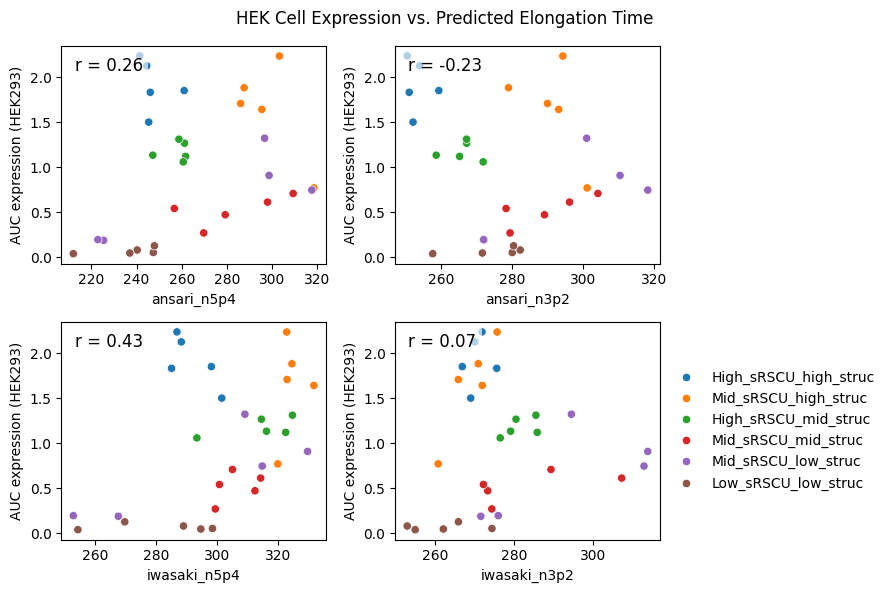

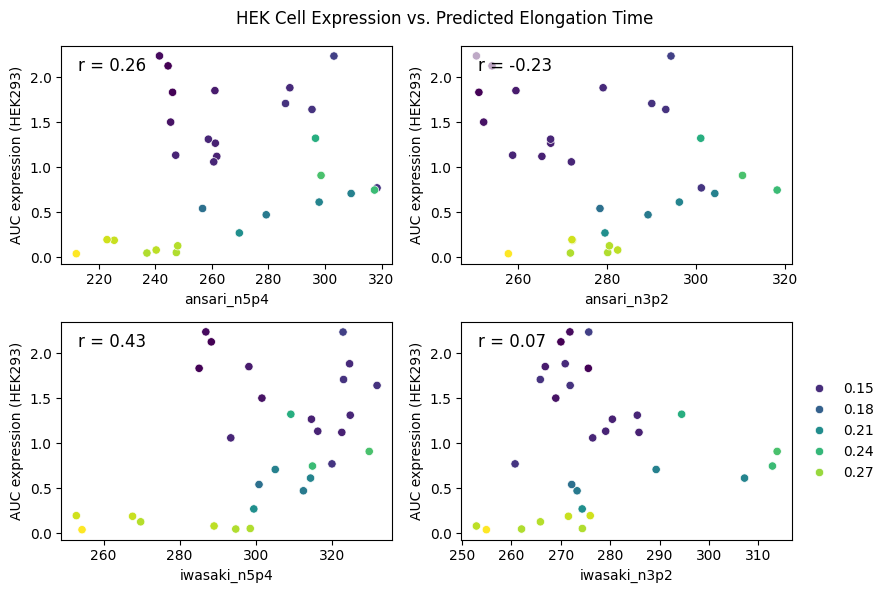

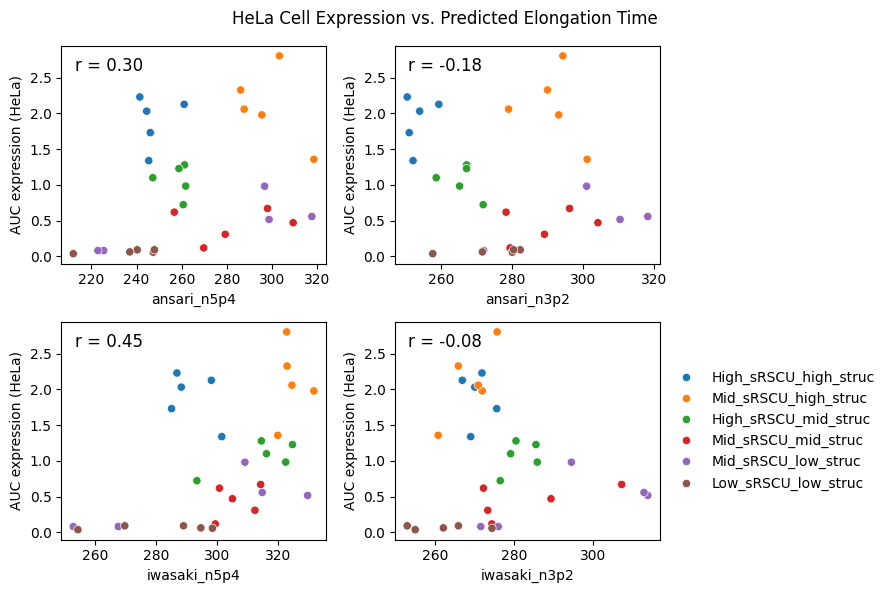

In [82]:
def scatter(df, x, y, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    sns.scatterplot(
        df,
        x = x,
        y = y, 
        # hue = hue,
        ax=ax,
        **kwargs
    )
    r = df[x].corr(df[y], method="pearson")
    # ax.legend(title="sequence class", **legend_kwargs())
    ax.text(0.05, 0.95, f"r = {r:.2f}", transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.65))
    return ax

def superplot(df, y, title=None, **kwargs):
    fig, axs = plt.subplots(2, 2, figsize=(9, 6))
    scatter(df, "ansari_n5p4", y, ax=axs[0, 0], **kwargs)
    scatter(df, "ansari_n3p2", y, ax=axs[0, 1], **kwargs)
    scatter(df, "iwasaki_n5p4", y, ax=axs[1, 0], **kwargs)
    scatter(df, "iwasaki_n3p2", y, ax=axs[1, 1], **kwargs)
    if title is not None:
        fig.suptitle(title)
    axs[0, 0].legend().remove()
    axs[0, 1].legend().remove()
    axs[1, 0].legend().remove()
    axs[1, 1].legend(**legend_kwargs())
    fig.tight_layout()
    return axs
    # plt.show()

superplot(df, "AUC expression (HEK293)", "HEK Cell Expression vs. Predicted Elongation Time", hue = "sequence class", legend=True)
superplot(df, "AUC expression (HEK293)", "HEK Cell Expression vs. Predicted Elongation Time", hue = "U Content", legend=True, palette="viridis")
superplot(df, "AUC expression (HeLa)", "HeLa Cell Expression vs. Predicted Elongation Time", hue = "sequence class", legend=True)
# superplot("Mean ribosome load (HEK293)")
# superplot("Mean ribosome load (HeLa)")


/tmp/ipykernel_12365/3810518803.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 0].legend().remove()
/tmp/ipykernel_12365/3810518803.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 1].legend().remove()
/tmp/ipykernel_12365/3810518803.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 0].legend().remove()
/tmp/ipykernel_12365/3810518803.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 1].legend(**legend_kwargs())


array([[<Axes: xlabel='ansari_n5p4', ylabel='Elongation rate (codons/s)'>,
        <Axes: xlabel='ansari_n3p2', ylabel='Elongation rate (codons/s)'>],
       [<Axes: xlabel='iwasaki_n5p4', ylabel='Elongation rate (codons/s)'>,
        <Axes: xlabel='iwasaki_n3p2', ylabel='Elongation rate (codons/s)'>]],
      dtype=object)

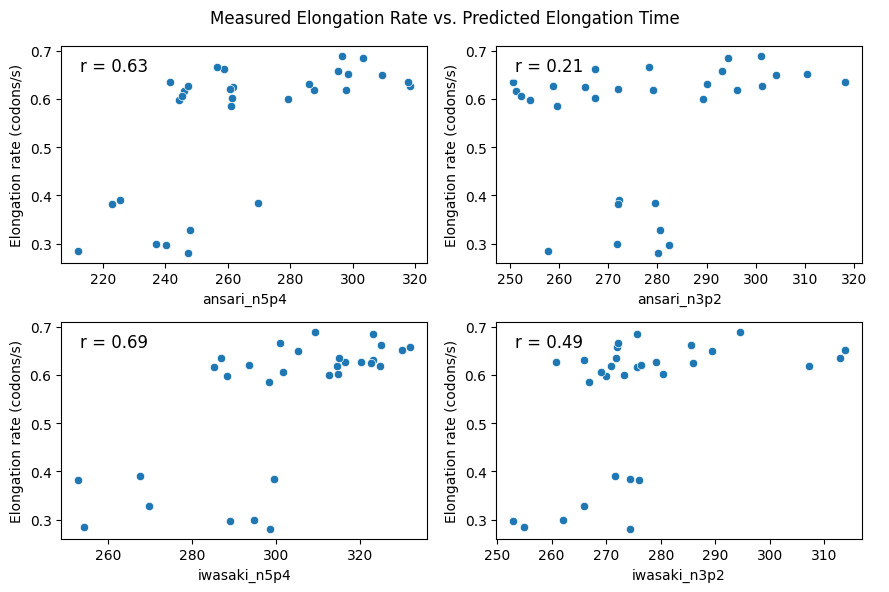

In [83]:
superplot(df, "Elongation rate (codons/s)", "Measured Elongation Rate vs. Predicted Elongation Time")

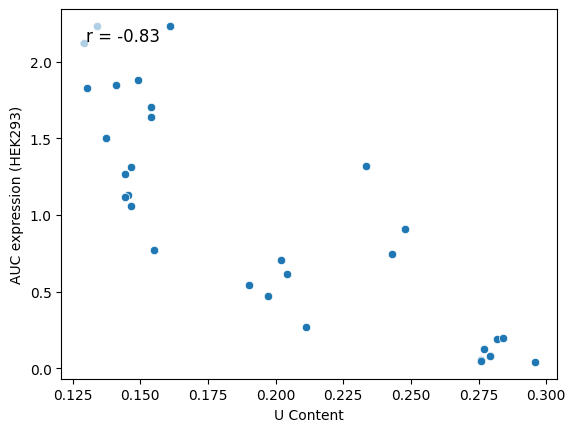

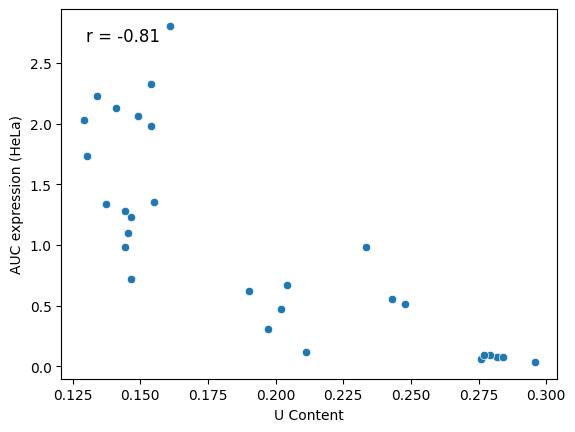

In [84]:
# df.loc[:, "iXnos mean"] = df[["ansari_n5p4", "ansari_n3p2", "iwasaki_n5p4", "iwasaki_n3p2"]].mean(axis=1)
fig, ax = plt.subplots()
sns.scatterplot(
    df,
    x = "U Content",
    y = "AUC expression (HEK293)",
    # hue = "iXnos mean", palette="viridis",
    ax=ax
)
r = df["U Content"].corr(df["AUC expression (HEK293)"], method="pearson")
# ax.legend(title="sequence class", **legend_kwargs())
ax.text(0.05, 0.95, f"r = {r:.2f}", transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', horizontalalignment='left', 
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.65))
plt.show()


fig, ax = plt.subplots()
sns.scatterplot(
    df,
    x = "U Content",
    y = "AUC expression (HeLa)",
    # hue = "iXnos mean", palette="viridis",
    ax=ax
)
r = df["U Content"].corr(df["AUC expression (HeLa)"], method="pearson")
# ax.legend(title="sequence class", **legend_kwargs())
ax.text(0.05, 0.95, f"r = {r:.2f}", transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', horizontalalignment='left', 
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.65))
plt.show()

## Sahim data

In [85]:
sahim_seqs = [
    "ATGAGTAAGGGGGAGGAGTTGTTTACTGGTGTTGTACCAATTCTTGTTGAATTGGATGGTGATGTGAATGGTCATAAGTTTAGTGTTAGTGGTGAGGGTGAGGGGGACGCGACGTATGGTAAGTTGACTCTTAAGTTTATTTGTACCACCGGTAAATTGCCCGTGCCATGGCCCACGCTGGTGACGACGCTGGGTTATGGTTTGATGTGTTTTGCACGTTACCCCGACCATATGAAGCAGCATGATTTTTTTAAGAGTGCGATGCCAGAGGGTTACGTGCAGGAGCGGACGATTTTTTTTAAGGATGATGGTAATTATAAAACCCGGGCGGAGGTGAAGTTTGAGGGTGATACGTTGGTGAATAGGATTGAGTTGAAGGGGATTGATTTTAAGGAGGATGGTAATATATTGGGTCATAAGTTAGAGTATAATTATAATAGCCATAATGTATATATTATGGCTGATAAACAAAAGAATGGTATTAAGGTGAATTTTAAGATTAGGCATAATATTGAGGATGGTTCGGTCCAGCTGGCGGATCATTATCAACAAAATACCCCAATTGGTGATGGTCCTGTATTGCTCCCCGATAATCATTATTTGTCGTATCAGTCGGCGCTGTCGAAGGACCCCAATGAGAAGAGGGACCATATGGTGCTGCTGGAGTTTGTGACGGCGGCGGGGATCACGCATGGGATGGATGAGTTGTATAAATGA",
    "ATGAGTAAGGGAGAGGAATTGTTTACTGGAGTTGTACCTATTCTTGTGGAACTAGACGGGGACGTGAACGGTCACAAGTTTAGTGTCAGCGGAGAAGGTGAAGGTGATGCCACATACGGTAAATTGACCTTGAAATTTATTTGTACTACTGGCAAACTCCCTGTTCCCTGGCCCACACTCGTTACCACGTTAGGTTACGGTCTCATGTGCTTCGCGCGGTACCCAGATCATATGAAGCAGCATGACTTTTTTAAGAGTGCTATGCCCGAGGGTTACGTTCAGGAGCGCACCATATTTTTCAAAGATGATGGAAATTATAAGACCCGCGCAGAGGTAAAATTTGAAGGCGACACACTCGTCAATCGTATTGAGCTCAAAGGTATTGACTTTAAAGAAGACGGCAATATACTAGGCCATAAGCTTGAATATAATTATAATAGTCACAACGTCTACATCATGGCCGATAAGCAGAAGAATGGGATAAAGGTAAACTTCAAAATTCGTCACAACATCGAGGATGGATCTGTACAACTTGCTGACCATTACCAGCAGAACACACCGATAGGTGATGGTCCCGTCTTATTGCCCGACAATCATTATCTGAGCTATCAGTCGGCCCTGTCGAAAGACCCAAACGAGAAACGGGATCATATGGTCCTTCTGGAGTTTGTGACAGCGGCTGGCATAACCCATGGCATGGATGAGTTGTATAAATGA",
    "ATGTCCAAAGGTGAAGAGTTGTTCACTGGGGTGGTACCCATCCTCGTCGAATTAGATGGCGACGTAAATGGTCATAAATTTTCGGTCAGTGGGGAGGGGGAAGGCGATGCAACTTACGGAAAGCTGACTTTAAAATTCATCTGCACAACAGGTAAACTGCCTGTCCCATGGCCAACCCTAGTGACCACCCTCGGTTATGGCTTGATGTGCTTCGCGCGGTATCCTGATCACATGAAACAGCACGACTTCTTTAAGTCCGCCATGCCGGAAGGTTATGTACAAGAACGCACTATTTTCTTTAAGGATGATGGAAACTATAAAACCAGAGCGGAGGTTAAATTCGAGGGGGATACCCTTGTGAACCGCATAGAGCTGAAAGGCATCGACTTTAAGGAGGATGGAAATATACTTGGACACAAGTTGGAGTATAATTACAATTCTCACAACGTCTACATCATGGCGGATAAACAGAAGAATGGGATTAAGGTGAACTTCAAAATTCGTCATAATATAGAAGATGGGTCAGTGCAACTAGCTGACCATTATCAGCAAAACACGCCGATCGGTGATGGACCTGTGTTACTTCCTGATAATCATTACCTGTCATATCAGTCTGCACTAAGCAAGGACCCAAACGAAAAAAGGGACCACATGGTGCTTTTAGAGTTCGTCACTGCGGCGGGGATCACGCACGGGATGGATGAACTTTATAAATGA",
    "ATGTCTAAGGGCGAAGAGCTATTTACGGGGGTTGTACCTATCCTAGTCGAACTTGACGGGGACGTGAATGGTCATAAATTTAGCGTATCTGGCGAGGGGGAGGGAGACGCAACGTACGGAAAGTTGACACTAAAATTCATCTGTACAACCGGCAAACTACCAGTCCCATGGCCCACACTAGTAACCACTTTAGGGTACGGACTAATGTGTTTCGCTAGGTATCCAGACCACATGAAGCAACATGACTTTTTCAAATCTGCTATGCCTGAAGGTTATGTCCAAGAACGAACGATTTTTTTCAAAGACGATGGAAACTACAAAACCAGAGCGGAGGTGAAATTCGAGGGAGATACTCTGGTTAACCGGATTGAGTTAAAAGGGATTGATTTTAAAGAGGACGGCAATATTTTGGGTCATAAACTAGAATACAACTATAATAGCCATAACGTGTATATAATGGCCGACAAACAGAAAAATGGTATAAAAGTAAACTTCAAAATTCGTCATAACATTGAAGATGGAAGTGTGCAGCTTGCGGATCACTATCAACAAAACACACCGATTGGCGACGGGCCGGTTCTACTACCGGACAATCATTATCTAAGCTATCAGAGTGCTCTATCCAAGGATCCTAATGAGAAGCGGGACCATATGGTCCTACTGGAGTTCGTTACGGCAGCTGGGATCACACATGGTATGGATGAGCTTTACAAATGA",
    "ATGAGTAAGGGGGAGGAGTTGTTTACTGGAGTCGTTCCTATTCTGGTGGAGTTAGACGGAGACGTCAATGGACATAAATTCTCAGTTTCCGGCGAAGGGGAAGGAGATGCAACCTACGGGAAGCTTACTCTAAAGTTCATATGCACAACTGGCAAGCTTCCGGTGCCATGGCCTACTTTAGTAACGACCCTGGGGTACGGATTGATGTGTTTCGCAAGGTATCCCGATCATATGAAACAGCACGACTTCTTTAAATCTGCCATGCCCGAAGGGTACGTTCAAGAGAGGACAATATTTTTCAAGGATGACGGAAATTACAAAACCCGTGCAGAAGTGAAGTTCGAAGGCGATACATTAGTTAACAGGATAGAACTGAAAGGGATCGATTTCAAAGAAGACGGTAATATTCTTGGACATAAGCTAGAATACAACTATAACAGTCACAATGTCTACATCATGGCGGACAAGCAGAAAAACGGCATCAAGGTAAATTTCAAAATACGGCACAACATCGAAGACGGATCAGTACAGCTGGCAGACCACTACCAGCAAAACACACCTATTGGCGATGGCCCTGTTTTACTTCCGGACAACCACTATTTATCCTACCAGTCCGCGTTGTCGAAAGATCCTAACGAAAAGCGAGATCATATGGTTTTGTTGGAATTTGTAACTGCTGCTGGAATTACACATGGTATGGACGAATTATATAAATGA",
    "ATGAGCAAAGGAGAAGAGTTATTCACAGGCGTCGTTCCGATACTAGTCGAACTAGACGGAGACGTCAACGGACACAAATTCTCAGTATCCGGAGAAGGAGAAGGAGACGCTACCTACGGGAAACTTACGCTAAAATTCATATGCACAACGGGGAAACTACCTGTCCCGTGGCCTACTCTAGTCACAACCCTAGGATACGGACTAATGTGCTTCGCTCGATACCCGGATCACATGAAACAACACGACTTCTTCAAATCGGCCATGCCCGAAGGATATGTCCAAGAAAGGACAATATTCTTCAAAGACGACGGAAACTACAAAACGCGAGCAGAGGTCAAATTCGAAGGAGACACGTTAGTCAACAGAATCGAACTGAAAGGCATAGACTTCAAGGAAGACGGAAACATCCTAGGACACAAACTGGAATACAATTACAATTCTCACAACGTGTACATAATGGCAGACAAACAGAAAAACGGAATAAAAGTCAACTTCAAGATACGACACAACATAGAAGACGGATCTGTTCAGCTAGCAGACCACTACCAGCAGAACACACCAATTGGAGACGGACCAGTTCTGCTTCCCGACAACCACTATCTATCTTACCAGAGCGCTCTATCCAAAGATCCTAACGAAAAGCGAGATCACATGGTCCTACTAGAATTCGTAACAGCAGCAGGCATAACACACGGAATGGACGAACTTTACAAATGA",
]
scores = [132.595560933, 212.500182193, 247.345849672, 255.400404295, 293.12011958, 393.606701321]
ansari_n5p4_scores = [ansari_n5p4.predict_elongation(i) for i in sahim_seqs]
iwasaki_n5p4_scores = [iwasaki_n5p4.predict_elongation(i) for i in sahim_seqs]
ansari_n3p2_scores = [ansari_n3p2.predict_elongation(i) for i in sahim_seqs]
iwasaki_n3p2_scores = [iwasaki_n3p2.predict_elongation(i) for i in sahim_seqs]

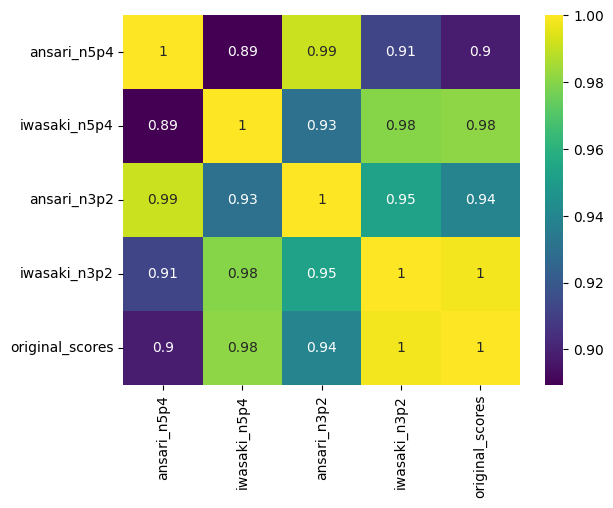

In [86]:
citrine_df = pd.DataFrame({
    "ansari_n5p4" : ansari_n5p4_scores,
    "iwasaki_n5p4" : iwasaki_n5p4_scores,
    "ansari_n3p2" : ansari_n3p2_scores,
    "iwasaki_n3p2" : iwasaki_n3p2_scores,
    "original_scores" : scores,
})
sns.heatmap(
    citrine_df.corr(method="pearson"),
    annot=True, cmap="viridis"
    )
plt.yticks(rotation=0)
plt.show()

Make a combined dataframe with the fluorescence data + sequences and original scores

In [87]:
sahim_info = {
    "citmin" : {
        "score": 132.595560933,
        "seq": "ATGAGTAAGGGGGAGGAGTTGTTTACTGGTGTTGTACCAATTCTTGTTGAATTGGATGGTGATGTGAATGGTCATAAGTTTAGTGTTAGTGGTGAGGGTGAGGGGGACGCGACGTATGGTAAGTTGACTCTTAAGTTTATTTGTACCACCGGTAAATTGCCCGTGCCATGGCCCACGCTGGTGACGACGCTGGGTTATGGTTTGATGTGTTTTGCACGTTACCCCGACCATATGAAGCAGCATGATTTTTTTAAGAGTGCGATGCCAGAGGGTTACGTGCAGGAGCGGACGATTTTTTTTAAGGATGATGGTAATTATAAAACCCGGGCGGAGGTGAAGTTTGAGGGTGATACGTTGGTGAATAGGATTGAGTTGAAGGGGATTGATTTTAAGGAGGATGGTAATATATTGGGTCATAAGTTAGAGTATAATTATAATAGCCATAATGTATATATTATGGCTGATAAACAAAAGAATGGTATTAAGGTGAATTTTAAGATTAGGCATAATATTGAGGATGGTTCGGTCCAGCTGGCGGATCATTATCAACAAAATACCCCAATTGGTGATGGTCCTGTATTGCTCCCCGATAATCATTATTTGTCGTATCAGTCGGCGCTGTCGAAGGACCCCAATGAGAAGAGGGACCATATGGTGCTGCTGGAGTTTGTGACGGCGGCGGGGATCACGCATGGGATGGATGAGTTGTATAAATGA"
    },

    "cit0" : {
        "score": 212.500182193,
        "seq": "ATGAGTAAGGGAGAGGAATTGTTTACTGGAGTTGTACCTATTCTTGTGGAACTAGACGGGGACGTGAACGGTCACAAGTTTAGTGTCAGCGGAGAAGGTGAAGGTGATGCCACATACGGTAAATTGACCTTGAAATTTATTTGTACTACTGGCAAACTCCCTGTTCCCTGGCCCACACTCGTTACCACGTTAGGTTACGGTCTCATGTGCTTCGCGCGGTACCCAGATCATATGAAGCAGCATGACTTTTTTAAGAGTGCTATGCCCGAGGGTTACGTTCAGGAGCGCACCATATTTTTCAAAGATGATGGAAATTATAAGACCCGCGCAGAGGTAAAATTTGAAGGCGACACACTCGTCAATCGTATTGAGCTCAAAGGTATTGACTTTAAAGAAGACGGCAATATACTAGGCCATAAGCTTGAATATAATTATAATAGTCACAACGTCTACATCATGGCCGATAAGCAGAAGAATGGGATAAAGGTAAACTTCAAAATTCGTCACAACATCGAGGATGGATCTGTACAACTTGCTGACCATTACCAGCAGAACACACCGATAGGTGATGGTCCCGTCTTATTGCCCGACAATCATTATCTGAGCTATCAGTCGGCCCTGTCGAAAGACCCAAACGAGAAACGGGATCATATGGTCCTTCTGGAGTTTGTGACAGCGGCTGGCATAACCCATGGCATGGATGAGTTGTATAAATGA"
    },
    "cit3" : {
        "score": 247.345849672,
        "seq": "ATGTCCAAAGGTGAAGAGTTGTTCACTGGGGTGGTACCCATCCTCGTCGAATTAGATGGCGACGTAAATGGTCATAAATTTTCGGTCAGTGGGGAGGGGGAAGGCGATGCAACTTACGGAAAGCTGACTTTAAAATTCATCTGCACAACAGGTAAACTGCCTGTCCCATGGCCAACCCTAGTGACCACCCTCGGTTATGGCTTGATGTGCTTCGCGCGGTATCCTGATCACATGAAACAGCACGACTTCTTTAAGTCCGCCATGCCGGAAGGTTATGTACAAGAACGCACTATTTTCTTTAAGGATGATGGAAACTATAAAACCAGAGCGGAGGTTAAATTCGAGGGGGATACCCTTGTGAACCGCATAGAGCTGAAAGGCATCGACTTTAAGGAGGATGGAAATATACTTGGACACAAGTTGGAGTATAATTACAATTCTCACAACGTCTACATCATGGCGGATAAACAGAAGAATGGGATTAAGGTGAACTTCAAAATTCGTCATAATATAGAAGATGGGTCAGTGCAACTAGCTGACCATTATCAGCAAAACACGCCGATCGGTGATGGACCTGTGTTACTTCCTGATAATCATTACCTGTCATATCAGTCTGCACTAAGCAAGGACCCAAACGAAAAAAGGGACCACATGGTGCTTTTAGAGTTCGTCACTGCGGCGGGGATCACGCACGGGATGGATGAACTTTATAAATGA"
    },

    "cit6" : {
        "score": 255.400404295,
        "seq": "ATGTCTAAGGGCGAAGAGCTATTTACGGGGGTTGTACCTATCCTAGTCGAACTTGACGGGGACGTGAATGGTCATAAATTTAGCGTATCTGGCGAGGGGGAGGGAGACGCAACGTACGGAAAGTTGACACTAAAATTCATCTGTACAACCGGCAAACTACCAGTCCCATGGCCCACACTAGTAACCACTTTAGGGTACGGACTAATGTGTTTCGCTAGGTATCCAGACCACATGAAGCAACATGACTTTTTCAAATCTGCTATGCCTGAAGGTTATGTCCAAGAACGAACGATTTTTTTCAAAGACGATGGAAACTACAAAACCAGAGCGGAGGTGAAATTCGAGGGAGATACTCTGGTTAACCGGATTGAGTTAAAAGGGATTGATTTTAAAGAGGACGGCAATATTTTGGGTCATAAACTAGAATACAACTATAATAGCCATAACGTGTATATAATGGCCGACAAACAGAAAAATGGTATAAAAGTAAACTTCAAAATTCGTCATAACATTGAAGATGGAAGTGTGCAGCTTGCGGATCACTATCAACAAAACACACCGATTGGCGACGGGCCGGTTCTACTACCGGACAATCATTATCTAAGCTATCAGAGTGCTCTATCCAAGGATCCTAATGAGAAGCGGGACCATATGGTCCTACTGGAGTTCGTTACGGCAGCTGGGATCACACATGGTATGGATGAGCTTTACAAATGA"
    },

    "cit9" : {
        "score": 293.12011958,
        "seq": "ATGAGTAAGGGGGAGGAGTTGTTTACTGGAGTCGTTCCTATTCTGGTGGAGTTAGACGGAGACGTCAATGGACATAAATTCTCAGTTTCCGGCGAAGGGGAAGGAGATGCAACCTACGGGAAGCTTACTCTAAAGTTCATATGCACAACTGGCAAGCTTCCGGTGCCATGGCCTACTTTAGTAACGACCCTGGGGTACGGATTGATGTGTTTCGCAAGGTATCCCGATCATATGAAACAGCACGACTTCTTTAAATCTGCCATGCCCGAAGGGTACGTTCAAGAGAGGACAATATTTTTCAAGGATGACGGAAATTACAAAACCCGTGCAGAAGTGAAGTTCGAAGGCGATACATTAGTTAACAGGATAGAACTGAAAGGGATCGATTTCAAAGAAGACGGTAATATTCTTGGACATAAGCTAGAATACAACTATAACAGTCACAATGTCTACATCATGGCGGACAAGCAGAAAAACGGCATCAAGGTAAATTTCAAAATACGGCACAACATCGAAGACGGATCAGTACAGCTGGCAGACCACTACCAGCAAAACACACCTATTGGCGATGGCCCTGTTTTACTTCCGGACAACCACTATTTATCCTACCAGTCCGCGTTGTCGAAAGATCCTAACGAAAAGCGAGATCATATGGTTTTGTTGGAATTTGTAACTGCTGCTGGAATTACACATGGTATGGACGAATTATATAAATGA"
    },

    "citmax" : {
        "score": 393.606701321,
        "seq": "ATGAGCAAAGGAGAAGAGTTATTCACAGGCGTCGTTCCGATACTAGTCGAACTAGACGGAGACGTCAACGGACACAAATTCTCAGTATCCGGAGAAGGAGAAGGAGACGCTACCTACGGGAAACTTACGCTAAAATTCATATGCACAACGGGGAAACTACCTGTCCCGTGGCCTACTCTAGTCACAACCCTAGGATACGGACTAATGTGCTTCGCTCGATACCCGGATCACATGAAACAACACGACTTCTTCAAATCGGCCATGCCCGAAGGATATGTCCAAGAAAGGACAATATTCTTCAAAGACGACGGAAACTACAAAACGCGAGCAGAGGTCAAATTCGAAGGAGACACGTTAGTCAACAGAATCGAACTGAAAGGCATAGACTTCAAGGAAGACGGAAACATCCTAGGACACAAACTGGAATACAATTACAATTCTCACAACGTGTACATAATGGCAGACAAACAGAAAAACGGAATAAAAGTCAACTTCAAGATACGACACAACATAGAAGACGGATCTGTTCAGCTAGCAGACCACTACCAGCAGAACACACCAATTGGAGACGGACCAGTTCTGCTTCCCGACAACCACTATCTATCTTACCAGAGCGCTCTATCCAAAGATCCTAACGAAAAGCGAGATCACATGGTCCTACTAGAATTCGTAACAGCAGCAGGCATAACACACGGAATGGACGAACTTTACAAATGA"
    },
}
sahim_info_df = pd.DataFrame(sahim_info).T.reset_index(names="cit")

In [88]:
fluorescence_df = pd.read_csv("processed-data/citrine_fluorescence.csv")
fdf_path = "processed-data/citrine_fluorescence_expanded.csv"
if not os.path.exists(fdf_path):
    # Remove modified mRNAs
    # fluorescence_df_unmod = fluorescence_df[fluorescence_df["mod"] != "M"]
    cit_df_all = sahim_info_df.merge(fluorescence_df, on="cit")
    # Save this dataframe
    cit_df_all.to_csv(fdf_path, index=False)
else:
    cit_df_all = pd.read_csv(fdf_path)

cit_df_all["U Content"] = cit_df_all["seq"].apply(lambda x: x.count("T") / len(x))
for aa in ["G", "A", "C"]:
    cit_df_all[f"{aa} Content"] = cit_df_all["seq"].apply(lambda x: x.count(aa) / len(x))
cit_df = cit_df_all[cit_df_all["mod"] != "M"]

In [89]:
cit_df_all

,cit,score,seq,rep,mod,fluorescence,elong_time,U Content,G Content,A Content,C Content
0,citmin,132.595561,ATGAGTAAGGGGGAGGAGTTGTTTACTGGTGTTGTACCAATTCTTG...,1,M,4320.149805,132.595561,0.299861,0.304045,0.263598,0.132497
1,citmin,132.595561,ATGAGTAAGGGGGAGGAGTTGTTTACTGGTGTTGTACCAATTCTTG...,2,M,3607.594873,132.595561,0.299861,0.304045,0.263598,0.132497
2,citmin,132.595561,ATGAGTAAGGGGGAGGAGTTGTTTACTGGTGTTGTACCAATTCTTG...,1,UM,1498.980005,132.595561,0.299861,0.304045,0.263598,0.132497
3,citmin,132.595561,ATGAGTAAGGGGGAGGAGTTGTTTACTGGTGTTGTACCAATTCTTG...,2,UM,1552.930017,132.595561,0.299861,0.304045,0.263598,0.132497
4,cit0,212.500182,ATGAGTAAGGGAGAGGAATTGTTTACTGGAGTTGTACCTATTCTTG...,1,M,3669.429834,212.500182,0.255230,0.242678,0.298466,0.203626
5,cit0,212.500182,ATGAGTAAGGGAGAGGAATTGTTTACTGGAGTTGTACCTATTCTTG...,2,M,3393.039941,212.500182,0.255230,0.242678,0.298466,0.203626
6,cit0,212.500182,ATGAGTAAGGGAGAGGAATTGTTTACTGGAGTTGTACCTATTCTTG...,1,UM,1373.649927,212.500182,0.255230,0.242678,0.298466,0.203626
7,cit0,212.500182,ATGAGTAAGGGAGAGGAATTGTTTACTGGAGTTGTACCTATTCTTG...,2,UM,1318.039941,212.500182,0.255230,0.242678,0.298466,0.203626
8,cit3,247.345850,ATGTCCAAAGGTGAAGAGTTGTTCACTGGGGTGGTACCCATCCTCG...,1,M,9347.874902,247.345850,0.242678,0.249651,0.304045,0.203626
9,cit3,247.345850,ATGTCCAAAGGTGAAGAGTTGTTCACTGGGGTGGTACCCATCCTCG...,2,M,12969.164453,247.345850,0.242678,0.249651,0.304045,0.203626


Apply all iXnos models to this dataframe

In [90]:
cit_df = apply_models(cit_df, "seq")

/tmp/ipykernel_12365/1982876220.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ansari_n5p4"] = df[seq_col].apply(ansari_n5p4.predict_elongation,)
/tmp/ipykernel_12365/1982876220.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ansari_n3p2"] = df[seq_col].apply(ansari_n3p2.predict_elongation,)
/tmp/ipykernel_12365/1982876220.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

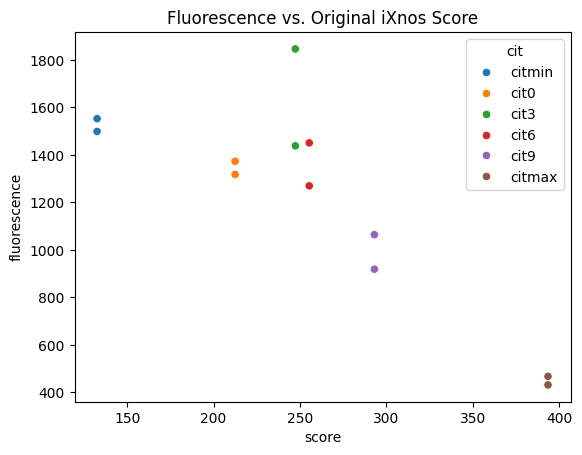

In [91]:
sns.scatterplot(
    cit_df,
    x = "score",
    y = "fluorescence",
    hue = "cit")
plt.title("Fluorescence vs. Original iXnos Score")
plt.show()
# sns.scatterplot(
#     cit_df,
#     x = "score",
#     y = "fluorescence",
#     hue = "cit")
# plt.title("Fluorescence vs. Original iXnos Score")
# plt.yscale("log")
# plt.show()

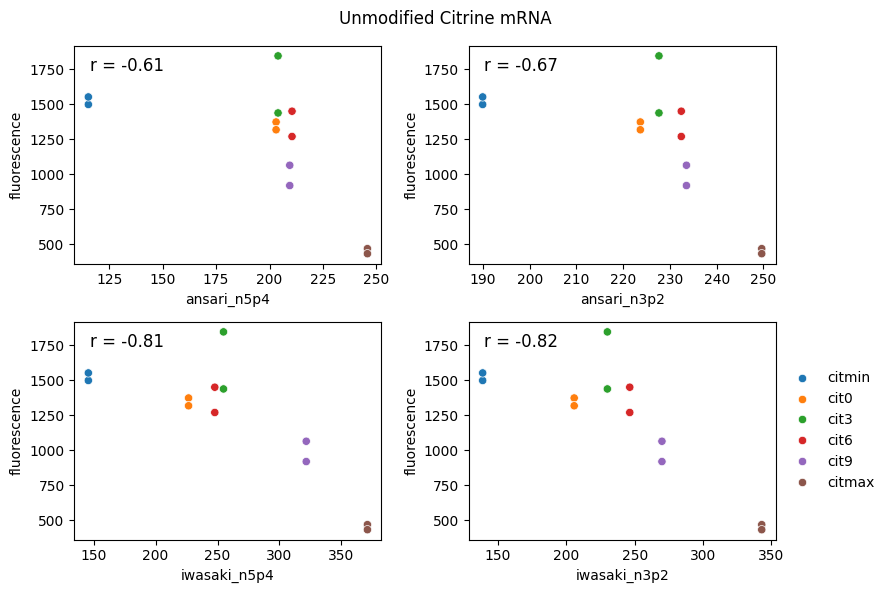

In [92]:
superplot(cit_df, "fluorescence", hue="cit", title="Unmodified Citrine mRNA")
plt.show()

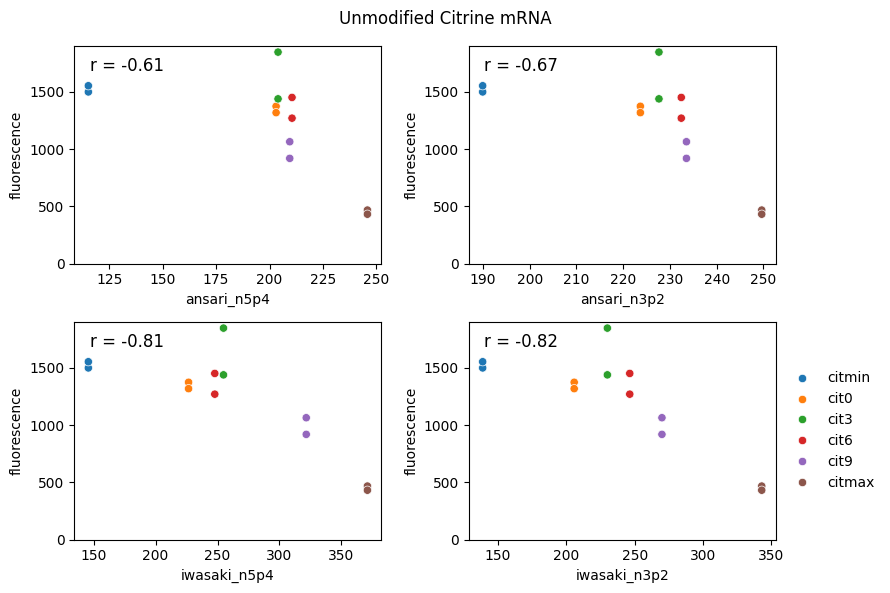

In [93]:
axs = superplot(cit_df, "fluorescence", hue="cit", title="Unmodified Citrine mRNA")
axs[0, 0].set_ylim(0, 1900)
axs[0, 1].set_ylim(0, 1900)
axs[1, 0].set_ylim(0, 1900)
axs[1, 1].set_ylim(0, 1900)
plt.show()

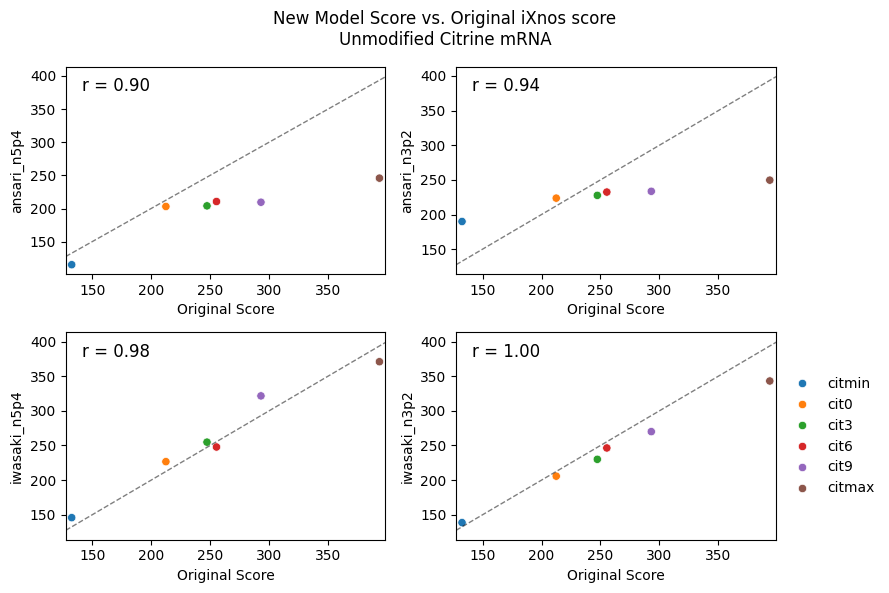

In [94]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
df = cit_df[cit_df["rep"] == 1]
xmin, xmax = df["score"].min() - 5, df["score"].max() + 5

scatter(df, "score", "ansari_n5p4", ax=axs[0, 0], hue="cit")
scatter(df, "score", "ansari_n3p2", ax=axs[0, 1], hue="cit")
scatter(df, "score", "iwasaki_n5p4", ax=axs[1, 0], hue="cit")
scatter(df, "score", "iwasaki_n3p2", ax=axs[1, 1], hue="cit")

axs[0, 0].set_xlim(xmin, xmax)
axs[0, 1].set_xlim(xmin, xmax)
axs[1, 0].set_xlim(xmin, xmax)
axs[1, 1].set_xlim(xmin, xmax)

xran = np.arange(xmin, xmax+1)
axs[0, 0].plot(xran, xran, c='k', alpha=0.5, linewidth=1, linestyle="--")
axs[0, 1].plot(xran, xran, c='k', alpha=0.5, linewidth=1, linestyle="--")
axs[1, 0].plot(xran, xran, c='k', alpha=0.5, linewidth=1, linestyle="--")
axs[1, 1].plot(xran, xran, c='k', alpha=0.5, linewidth=1, linestyle="--")

axs[0, 0].legend().remove()
axs[0, 1].legend().remove()
axs[1, 0].legend().remove()
axs[1, 1].legend(**legend_kwargs())

# axs = superplot(cit_df[cit_df["rep"] == 1], "score", hue="cit", title="Original iXnos score vs. New Model Score\nUnmodified Citrine mRNA")
label = "Original Score"
axs[0, 0].set_xlabel(label)
axs[0, 1].set_xlabel(label)
axs[1, 0].set_xlabel(label)
axs[1, 1].set_xlabel(label)
fig.suptitle("New Model Score vs. Original iXnos score\nUnmodified Citrine mRNA")
fig.tight_layout()
plt.show()

Let's look at the modified mRNA data now

In [95]:
cit_df_mod = cit_df_all[cit_df_all["mod"] == "M"]
cit_df_mod = apply_models(cit_df_mod, "seq")

/tmp/ipykernel_12365/1982876220.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ansari_n5p4"] = df[seq_col].apply(ansari_n5p4.predict_elongation,)
/tmp/ipykernel_12365/1982876220.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ansari_n3p2"] = df[seq_col].apply(ansari_n3p2.predict_elongation,)
/tmp/ipykernel_12365/1982876220.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

array([[<Axes: xlabel='ansari_n5p4', ylabel='fluorescence'>,
        <Axes: xlabel='ansari_n3p2', ylabel='fluorescence'>],
       [<Axes: xlabel='iwasaki_n5p4', ylabel='fluorescence'>,
        <Axes: xlabel='iwasaki_n3p2', ylabel='fluorescence'>]],
      dtype=object)

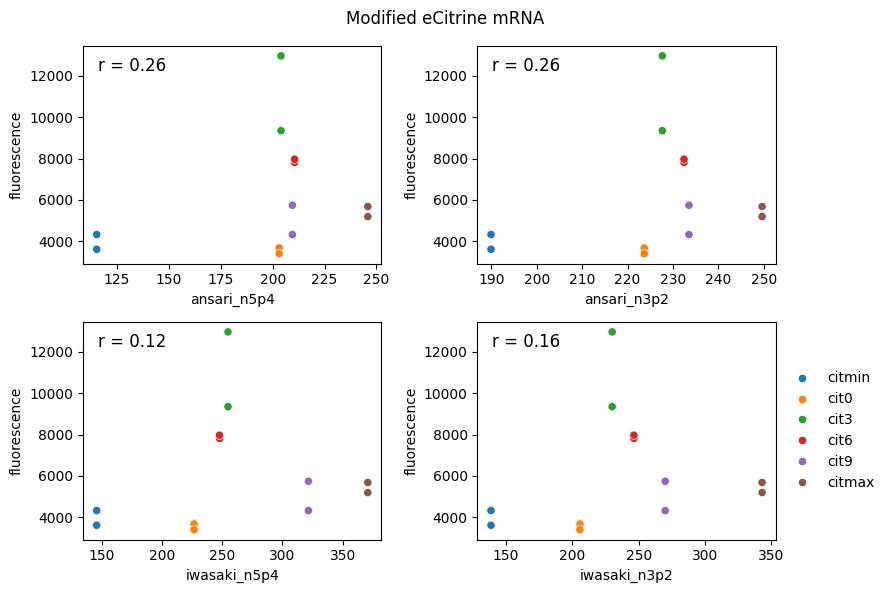

In [96]:
superplot(cit_df_mod, "fluorescence", hue="cit", title="Modified eCitrine mRNA")

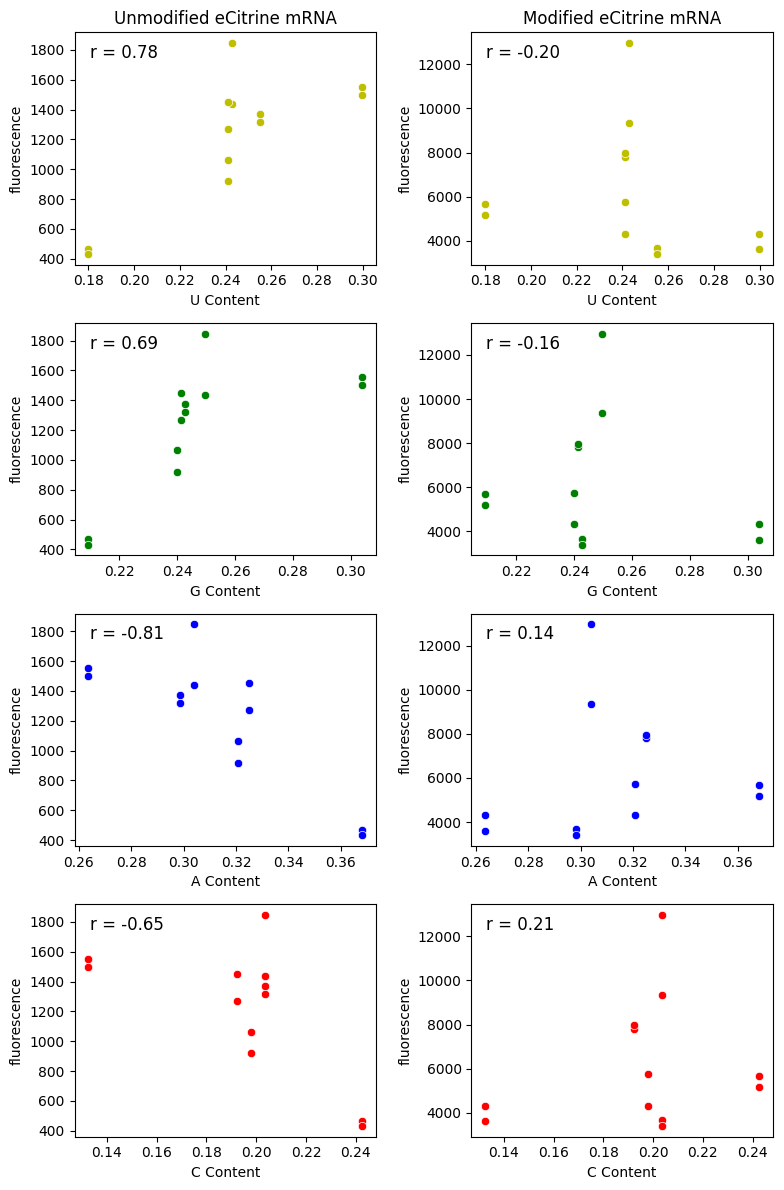

In [97]:
fig, axs = plt.subplots(4, 2, figsize=(8, 12))
colors = ['y', 'g', 'b', 'r']
for i, aa in enumerate(['U', 'G', 'A', 'C']):
    for j, cit_df_i in enumerate([cit_df, cit_df_mod]):
        sns.scatterplot(
            cit_df_i,
            x = f"{aa} Content",
            y = "fluorescence",
            c=colors[i],
            ax=axs[i, j]
        )
        r = cit_df_i[f"{aa} Content"].corr(cit_df_i["fluorescence"], method="pearson")
        # ax.legend(title="sequence class", **legend_kwargs())
        axs[i, j].text(0.05, 0.95, f"r = {r:.2f}", transform=axs[i, j].transAxes, 
                fontsize=12, verticalalignment='top', horizontalalignment='left', 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.65))
axs[0, 0].set_title("Unmodified eCitrine mRNA")
axs[0, 1].set_title("Modified eCitrine mRNA")

plt.tight_layout()
plt.show()

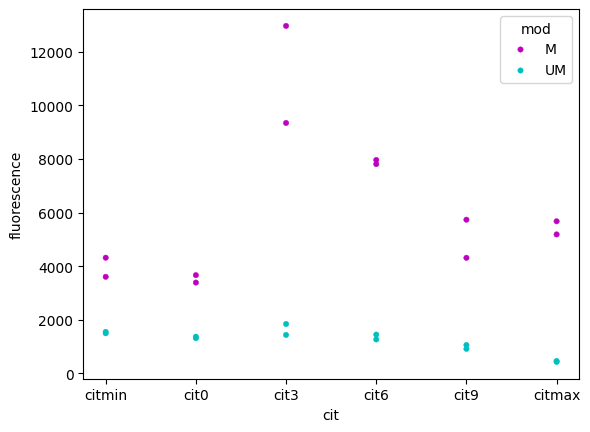

In [98]:
sns.scatterplot(
    cit_df_all,
    x="cit", y="fluorescence", hue="mod", s=15, edgecolor=None, palette=["m", "c"])
plt.show()